In [13]:
import numpy as np
import LC_funcs as lc
import matplotlib.pyplot as plt
from astropy.table import Table
import os

import math
from scipy.optimize import minimize
import emcee
import corner
from multiprocessing import Pool

from pytransit import QuadraticModel
from ldtk import LDPSetCreator, BoxcarFilter

from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

os.environ['OMP_NUM_THREADS']='1'
os.nice(19)

19

## Setting datasets

In [14]:
## Please change the following parameters
############################################
target='TOI5671.01'        #object name
date='220630'               # date for file names
date4plot='2022-Jul-1 UT'  # date to be shown in the plots

toi='5671'     # number of TOI
plnum='01'     # number of planet
tic=23863105   # number of TIC
initial='jd'   # your initial name
############################################

In [15]:
## Setting parameters

inst='muscat3'
bands = ['g','r','i','z']
nband = len(bands)


INST = {'muscat': 'MuSCAT',
        'muscat2': 'MuSCAT2',
        'muscat3': 'MuSCAT3'}

phot = []
    
for i in range(nband):
    photfile = 'TOI{0}.{1}L-{2}20{3}_{4}_{5}_measurements.csv'.format(toi, plnum, initial, date, INST[inst], bands[i])
    phot.append(Table.read(photfile))

## Limb darkening coefficients

In [16]:
### Filter setting for MuSCAT; Don't change.
filters = [BoxcarFilter('g', 430, 540),  # Define your passbands
           BoxcarFilter('r', 560, 700),  # - Boxcar filters useful in
           BoxcarFilter('i', 700, 820),
           BoxcarFilter('z', 830, 910)]  #   transmission spectroscopy

In [17]:
## Please change the value and error of stellar Teff, loog, and z (metallicity)
# Define your star, and the code downloads the uncached stellar spectra 
# from the Husser et al. FTP server automatically.
############################################
sc = LDPSetCreator(teff=(3380, 157),    # Define your star, and the code
                   logg=(4.81894, 0.00440884),    # downloads the uncached stellar
                      z=(0.408427, 0.0125522),    # spectra from the Husser et al.
                     filters=filters)    # FTP server automatically.
############################################

In [18]:
%%time

## LDTK ##
ps = sc.create_profiles()                # Create the limb darkening profiles
cq,eq = ps.coeffs_qd(do_mc=True)         # Estimate quadratic law coefficients

qc,qe = ps.coeffs_qd()
ldc = []
for i in range(len(ps._filters)):
    print(ps._filters[i], qc[i][0], qc[i][1])
    ldc.append((qc[i][0], qc[i][1]))

print(ldc)

g 0.620998489725331 0.22543723332980675
r 0.5756792293741856 0.17631347062433095
i 0.36640531395562626 0.2788928012962437
z 0.29881502061317844 0.2910721287579164
[(0.620998489725331, 0.22543723332980675), (0.5756792293741856, 0.17631347062433095), (0.36640531395562626, 0.2788928012962437), (0.29881502061317844, 0.2910721287579164)]
CPU times: user 8.84 s, sys: 9.14 ms, total: 8.85 s
Wall time: 8.66 s


## Orbital parameters

In [19]:
## Please change the following values
###########
T0_TFOP = 2458365.260992    #BJD_TDB
T0e_TFOP = 0.0018235 #BJD_TDB
P_TFOP = 3.3079817  #days
Pe_TFOP = 0.0006559  #days

Ms_TFOP = 0.400962 # stellar mass in Msun
Mse_TFOP = 0.0205648
Rs_TFOP = 0.408427 # stellar radius in Rsun
Rse_TFOP =0.0125522

k_TFOP_ppm = 81180 #ppm

## Optional ##
T14_TFOP_h = 1.666  #hours
T14e_TFOP_h =  0.182  #hours
###########

In [20]:
## No need to change ##
T14_TFOP=T14_TFOP_h/24.
T14e_TFOP=T14e_TFOP_h/24.

rhos = Ms_TFOP/Rs_TFOP**3 # stellar deinsity in rho_sun
rhose = np.sqrt( (1/Rs_TFOP**3)**2 * Mse_TFOP**2\
                            + (3*Ms_TFOP/Rs_TFOP**4)**2 * Rse_TFOP**2 )

k_TFOP = np.sqrt(k_TFOP_ppm/1e6)

a_Rs_TFOP = (rhos/0.01342*P_TFOP**2)**(1/3)
a_Rse_TFOP = 1/3*(1/0.01342*P_TFOP**2)**(1/3) * rhos**(-2/3) * rhose
print('a_Rs_TFOP = {0:.2f} +/- {1:.2f}'.format(a_Rs_TFOP, a_Rse_TFOP))


epoch = int((np.median(phot[0]['BJD_TDB']) - T0_TFOP + 0.3)/P_TFOP)
Tc_TFOP = T0_TFOP + P_TFOP * epoch
Tce_TFOP = np.sqrt(T0e_TFOP**2 + (Pe_TFOP*epoch)**2)
print('Tc_TFOP = {0:.5f} +/- {1:.5f}'.format(Tc_TFOP, Tce_TFOP))
Tc_pred=Tc_TFOP-2450000

b_TFOP=np.sqrt(((1.+k_TFOP)**2-(a_Rs_TFOP*np.sin(np.pi*T14_TFOP/P_TFOP))**2)/(1-np.sin(np.pi*T14_TFOP/P_TFOP)**2))
print('b_TFOP = {0:.2f}'.format(b_TFOP))

global kwargs

kwargs = {
    'P': P_TFOP,
    'e': 0,
    'omega': 0,
    'ldc': ldc,
    'a_Rs': a_Rs_TFOP,
    'a_Rs_err': a_Rse_TFOP,
    'Tc_pred': Tc_TFOP - 2450000,
    ## optional, comment out if not used ###
    'T14': T14_TFOP,    #0.825728846912796 hrs
    'T14_err': T14e_TFOP,
#    'Tc_pred_err': Tce_TFOP,
    ###########
}

a_Rs_TFOP = 16.87 +/- 0.59
Tc_TFOP = 2459761.22927 +/- 0.27680
b_TFOP = 0.65


## Light curve fitting with optimized data

In [21]:
#first of all...
global x, y, ye, amass, ttr
x=[]   #time
y=[]   #flux
ye=[]   #flux_err
amass=[]   #airmass

for i in range(nband):
    x.append(phot[i]['BJD_TDB']-2450000.)
    y.append(phot[i]['Flux'])
    ye.append(phot[i]['Err'])
    amass.append(phot[i]['Airmass'])

ttr=[]
for i in range(nband):
    ttr.append(QuadraticModel())
    ttr[i].set_data(x[i])

In [22]:
def calc_chi2_linear(p):
    d = (p[0], p[1], p[2], p[3])
    int_t0 = int(x[0][0])
    chi2 = 0.
    for i in range(nband):
        flux_time = d[i]*(x[i]-int_t0)
        c = np.polyfit(amass[i], y[i]-flux_time, 1)
        chi2 = chi2 + np.sum( (y[i] - np.polyval(c, amass[i]) + flux_time)**2 / ye[i] / ye[i] )
    return chi2


def calc_chi2_tr_chromatic(p):
    Tc = p[0]
    b = p[1]
    a_Rs = p[2]
    k = (p[3], p[4], p[5], p[6])
    d = (p[7], p[8], p[9], p[10])

    if k[0] < 0.01 or k[1] < 0.01 or k[2] < 0.01 or k[3] < 0.01:
        return np.inf
    if k[0] > 0.5 or k[1] > 0.5 or k[2] > 0.5 or k[3] > 0.5:
        return np.inf
    if b < 0:
        b = -1.0*b
    if b > 1.0:
        return np.inf
    if a_Rs <= 0:
        return np.inf
    if b/a_Rs >= 1:
        return np.inf
    inc = math.acos(b/a_Rs)
    P = kwargs['P'] if 'P' in kwargs.keys() else 0
    e = kwargs['e'] if 'e' in kwargs.keys() else 0
    omega = kwargs['omega'] if 'omega' in kwargs.keys() else 0
    ldc = kwargs['ldc'] if 'ldc' in kwargs.keys() else [(0,0),(0,0),(0,0)]
    Tc0 = kwargs['Tc_pred'] if 'Tc_pred' in kwargs.keys() else 0.
    Tc0e = kwargs['Tc_pred_err'] if 'Tc_pred_err' in kwargs.keys() else 0.
    a_Rs0 = kwargs['a_Rs'] if 'a_Rs' in kwargs.keys() else 0.
    a_Rs0e = kwargs['a_Rs_err'] if 'a_Rs_err' in kwargs.keys() else 0.
    b0 = kwargs['b'] if 'b' in kwargs.keys() else 0.
    b0e = kwargs['b_err'] if 'b_err' in kwargs.keys() else 0.
    T140 = kwargs['T14'] if 'T14' in kwargs.keys() else 0.
    T140e = kwargs['T14_err'] if 'T14_err' in kwargs.keys() else 0.
    #Tc0 > 0. and abs(Tc - Tc0) > P/2.
    if Tc0 > 0. and abs(Tc - Tc0) > P/2:
        return  np.inf  
    
    chi2 = 0.
    for i in range(nband):
        flux_tr = ttr[i].evaluate_ps(k[i], ldc[i], Tc, P, a_Rs, inc, e, omega)
        flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
        c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
        chi2 = chi2 + np.sum( (y[i] - (np.polyval(c, amass[i])+d[i]*(x[i]-Tc)) * flux_tr)**2 / ye[i] / ye[i] )
    if Tc0 > 0. and  Tc0e > 0:
        chi2 = chi2 + ((Tc - Tc0)/Tc0e)**2
    if a_Rs0 > 0.:
        chi2 = chi2 + ((a_Rs - a_Rs0)/a_Rs0e)**2
    if b0 > 0.:
        chi2 = chi2 + ((b - b0)/b0e)**2
    if T140 > 0.:
        cosi = b / a_Rs
        sini = np.sqrt(1. - cosi**2)
        k_mean = np.mean(k)
        T14 = P/np.pi * math.asin(1./a_Rs*np.sqrt((1.+k_mean)**2 - b**2)/sini);
        chi2 = chi2 + (T14 - T140)**2/T140e**2   
    return chi2


def ln_like_tr_chromatic(p):
    return -calc_chi2_tr_chromatic(p)

In [23]:
%%time
## minimize for linear function
p0 = (0, 0, 0, 0)
res_lin = minimize(calc_chi2_linear, p0, method='Nelder-Mead')
print(res_lin.fun, res_lin.success, res_lin.x)
res_lin = minimize(calc_chi2_linear, res_lin.x, method='Nelder-Mead')
print(res_lin.fun, res_lin.success, res_lin.x)

ndata = len(x[0])+len(x[1])+len(x[2])+len(x[3])
npar_lin = len(res_lin.x)
print('npar(linear) = ', npar_lin)
bic_lin = res_lin.fun + npar_lin * np.log(ndata)
print('BIC(linear) = ', bic_lin)

39720.56024820478 True [0.00114672 0.00088526 0.00083054 0.00098305]
39720.56024820478 True [0.00114672 0.00088526 0.00083054 0.00098305]
npar(linear) =  4
BIC(linear) =  39748.18726731938
CPU times: user 225 ms, sys: 0 ns, total: 225 ms
Wall time: 241 ms


In [24]:
%%time
## minimize for transit+baseline model

Tc0 = Tc_TFOP - 2450000.
k0 = k_TFOP
a_Rs0 = a_Rs_TFOP
b0 = b_TFOP
d00, d10, d20, d30 = 0, 0, 0, 0
p0 = np.array( (Tc0, b0, a_Rs0, k0, k0, k0, k0, d00, d10, d20, d30) )

result = minimize(calc_chi2_tr_chromatic, p0, method='Nelder-Mead')
print(result.fun, result.success, result.x)
result = minimize(calc_chi2_tr_chromatic, result.x,  method='Nelder-Mead')
print(result.fun, result.x)

1917.6454604309847 True [ 9.76183244e+03  6.63107832e-01  1.39230190e+01  2.50496978e-01
  2.96596927e-01  3.01903436e-01  2.87952406e-01  4.79288613e-04
 -7.58412946e-05 -5.82357456e-04  4.75323951e-04]
1213.5197310416977 [ 9.76183232e+03  4.50776513e-01  1.64938914e+01  2.77660175e-01
  2.80403129e-01  2.82206177e-01  2.84121201e-01  4.42595670e-04
 -8.61264024e-05 -5.52305835e-04  4.42592526e-04]
CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.1 s


In [25]:
Tc0

9761.229269399773

ccd= 0


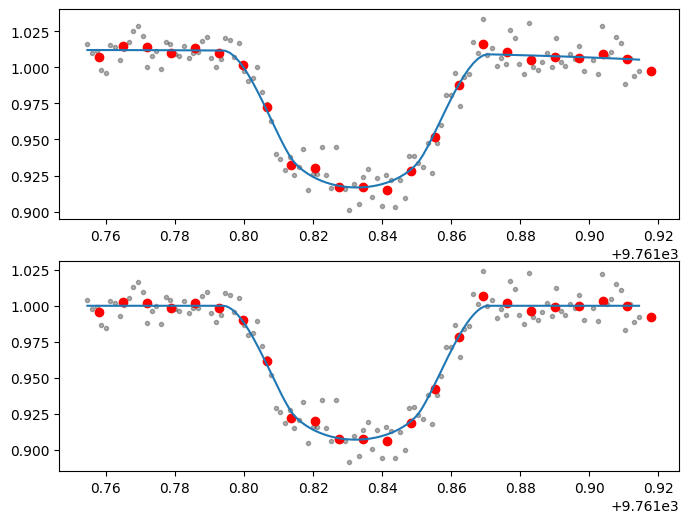

ccd= 1


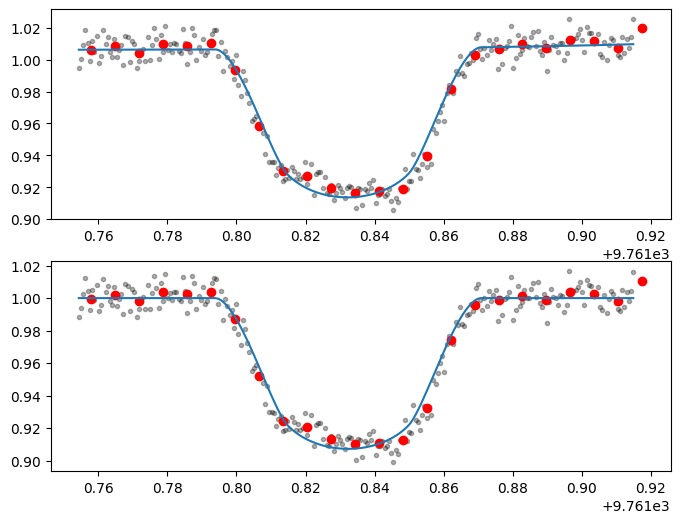

ccd= 2


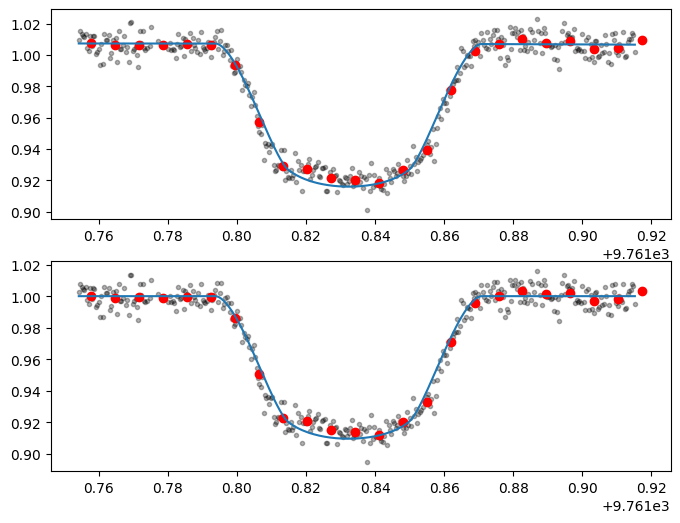

ccd= 3


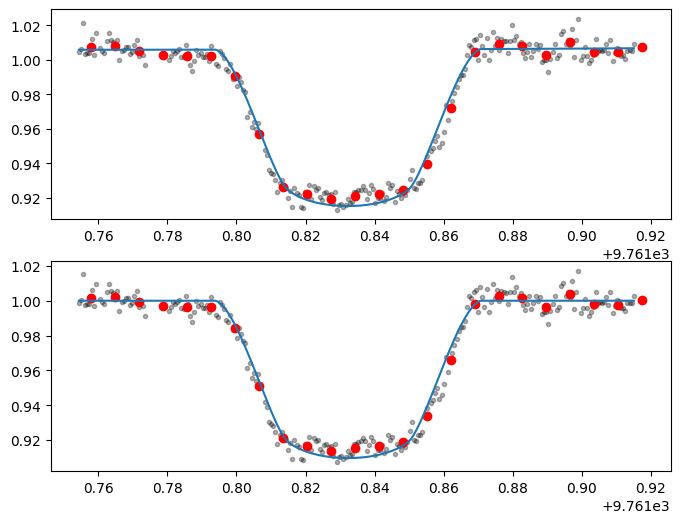

In [26]:
k = [0, 0, 0, 0]
d = [0, 0, 0, 0]
Tc, b, a_Rs, k[0], k[1], k[2], k[3], d[0], d[1], d[2], d[3] = result.x

P = kwargs['P']
e = kwargs['e']
omega = kwargs['omega']
inc = math.acos(b/a_Rs)

binsize=600/86400

#ymin=0.95
#ymax=1.05

for i in range(nband):
    print('ccd=',i)

    flux_tr = ttr[i].evaluate_ps(k[i], ldc[i], Tc, P, a_Rs, inc, e, omega)
    xmodel = np.linspace(np.min(x[i]), np.max(x[i]), 200)
    ttr_model = QuadraticModel()
    ttr_model.set_data(xmodel)
    ymodel = ttr_model.evaluate_ps(k[i], ldc[i], Tc, P, a_Rs, inc, e, omega)

    flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
    c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
    t0 = np.min(x[i])
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i], y[i], ye[i], binsize, t0)

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(x[i],y[i],'.k',alpha=0.3)
    ax[0].plot(tbin, ybin,'or')
    ax[0].plot(x[i], flux_tr * (np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)))
    #ax[0].set_ylim(ymin, ymax)
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i], y[i]/(np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)), ye[i], binsize, t0)
    ax[1].plot(x[i],y[i]/(np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)),'.k',alpha=0.3)
    ax[1].plot(tbin, ybin,'or')
    ax[1].plot(xmodel, ymodel)
    #ax[1].set_ylim(ymin, ymax)

    plt.show()

## Light curve fitting without outliers

In [27]:
#ridding outliers
############################################
sigma=5      #outlier threshold from light curve
############################################

In [28]:
for i in range(nband):
    flux_tr = ttr[i].evaluate_ps(k[i], ldc[i], Tc, P, a_Rs, inc, e, omega)
    flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
    c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
    flat=y[i]/(flux_tr * (np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)))
    x[i]=x[i][(flat>np.mean(flat)-sigma*np.std(flat))&(flat<np.mean(flat)+sigma*np.std(flat))]
    ye[i]=ye[i][(flat>np.mean(flat)-sigma*np.std(flat))&(flat<np.mean(flat)+sigma*np.std(flat))]
    amass[i]=amass[i][(flat>np.mean(flat)-sigma*np.std(flat))&(flat<np.mean(flat)+sigma*np.std(flat))]
    y[i]=y[i][(flat>np.mean(flat)-sigma*np.std(flat))&(flat<np.mean(flat)+sigma*np.std(flat))]
    
ttr=[]
for i in range(nband):
    ttr.append(QuadraticModel())
    ttr[i].set_data(x[i])

In [29]:
%%time
## minimize again if needed
result = minimize(calc_chi2_tr_chromatic, result.x,  method='Nelder-Mead')
print(result.fun, result.x)

1081.0764897938122 [ 9.76183238e+03  4.53513426e-01  1.58573207e+01  2.80867453e-01
  2.78767775e-01  2.78026194e-01  2.78611210e-01  4.60565727e-04
 -8.53791933e-05 -5.59711567e-04  4.67862207e-04]
CPU times: user 2.69 s, sys: 0 ns, total: 2.69 s
Wall time: 2.69 s


In [30]:
result.x

array([ 9.76183238e+03,  4.53513426e-01,  1.58573207e+01,  2.80867453e-01,
        2.78767775e-01,  2.78026194e-01,  2.78611210e-01,  4.60565727e-04,
       -8.53791933e-05, -5.59711567e-04,  4.67862207e-04])

In [31]:
%%time
## minimize for linear function
p0 = (0, 0, 0, 0)
res_lin = minimize(calc_chi2_linear, res_lin.x, method='Nelder-Mead')
print(res_lin.fun, res_lin.success, res_lin.x)


ndata = len(x[0])+len(x[1])+len(x[2])+len(x[3])
npar_lin = len(res_lin.x)
print('npar(linear) = ', npar_lin)
bic_lin = res_lin.fun + npar_lin * np.log(ndata)
print('BIC(linear) = ', bic_lin)

39720.56024820478 True [0.00114672 0.00088526 0.00083054 0.00098305]
npar(linear) =  4
BIC(linear) =  39748.18726731938
CPU times: user 70 ms, sys: 0 ns, total: 70 ms
Wall time: 68.8 ms


In [32]:
%%time
## minimize again if needed
result = minimize(calc_chi2_tr_chromatic, result.x,  method='Nelder-Mead')
print(result.fun, result.success, result.x)

989.2135722233709 False [ 9.76183239e+03  1.87080823e-01  1.74270458e+01  2.74090600e-01
  2.69695271e-01  2.70009602e-01  2.71724330e-01  4.84344137e-04
 -9.78216669e-05 -7.16943009e-04  5.23074245e-04]
CPU times: user 3.56 s, sys: 0 ns, total: 3.56 s
Wall time: 3.56 s


ccd= 0


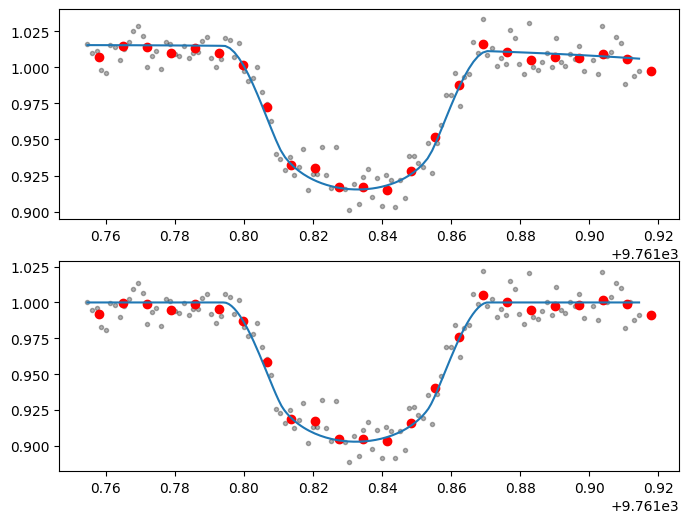

ccd= 1


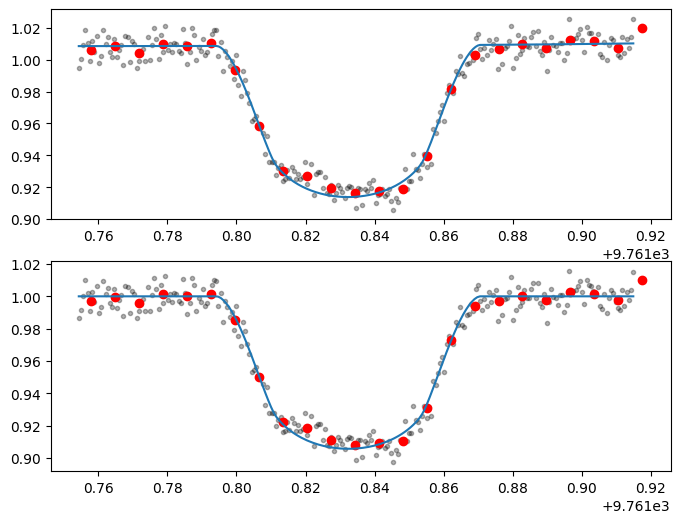

ccd= 2


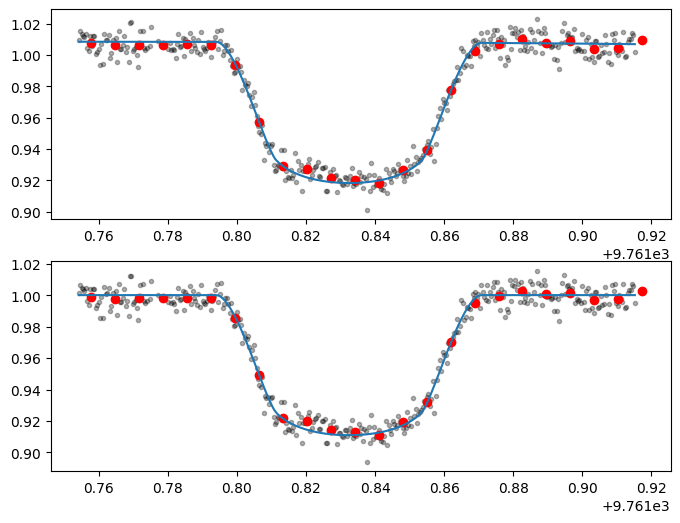

ccd= 3


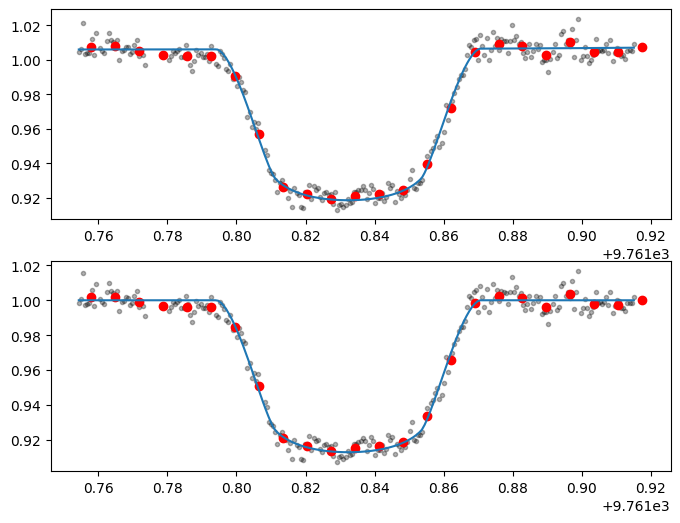

In [33]:
k = [0, 0, 0, 0]
d = [0, 0, 0, 0]
Tc, b, a_Rs, k[0], k[1], k[2], k[3], d[0], d[1], d[2], d[3] = result.x

P = kwargs['P']
e = kwargs['e']
omega = kwargs['omega']
inc = math.acos(b/a_Rs)

binsize=600/86400

#ymin=0.98
#ymax=1.015

for i in range(nband):
    print('ccd=',i)

    flux_tr = ttr[i].evaluate_ps(k, ldc[i], Tc, P, a_Rs, inc, e, omega)
    xmodel = np.linspace(np.min(x[i]), np.max(x[i]), 200)
    ttr_model = QuadraticModel()
    ttr_model.set_data(xmodel)
    ymodel = ttr_model.evaluate_ps(k, ldc[i], Tc, P, a_Rs, inc, e, omega)

    flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
    c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
    t0 = np.min(x[i])
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i], y[i], ye[i], binsize, t0)

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(x[i],y[i],'.k',alpha=0.3)
    ax[0].plot(tbin, ybin,'or')
    ax[0].plot(x[i], flux_tr * (np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)))
    #ax[0].set_ylim(ymin, ymax)
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i], y[i]/(np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)), ye[i], binsize, t0)
    ax[1].plot(x[i],y[i]/(np.polyval(c, amass[i]) + d[i]*(x[i]-Tc)),'.k',alpha=0.3)
    ax[1].plot(tbin, ybin,'or')
    ax[1].plot(xmodel, ymodel)
    #ax[1].set_ylim(ymin, ymax)

    plt.show()

In [34]:
# MCMC setting
############################################
nwalkers=50      #the number of walkers
nsteps = 10000   #the number of steps
############################################

In [35]:
%%time

ndim = len(result.x)
pos = [result.x + 1e-5*np.random.randn(ndim) for i in range(nwalkers)]

with Pool(12) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like_tr_chromatic, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)

100%|██████████| 10000/10000 [02:44<00:00, 60.83it/s]

CPU times: user 1min 26s, sys: 15.7 s, total: 1min 42s
Wall time: 2min 44s


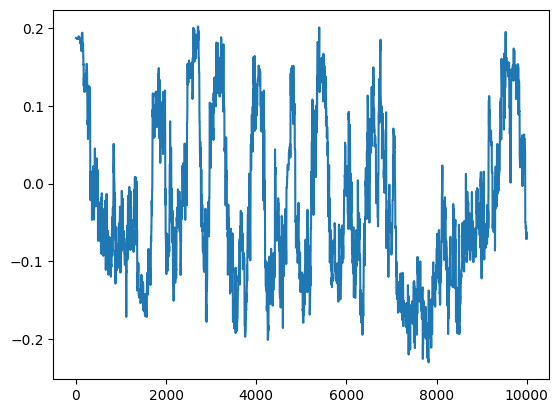

In [36]:
plt.plot(sampler.chain[0,:,1])

In [37]:
log_prob = sampler.get_log_prob()
argmax = np.argmax(log_prob)
j=int(argmax/nwalkers)
i=argmax-nwalkers*j
chain_best = sampler.flatchain[argmax]
chi2_best = -log_prob[j,i]
print(chi2_best)
npar_tr = len(chain_best)
print('ndata = ', ndata)
print('npar(transit+linear) = ', npar_tr)
bic_tr = chi2_best + npar_tr * np.log(ndata)
print('BIC(transit+linear) = ', bic_tr)

delta_bic = bic_lin - bic_tr
print('delta_BIC = ', delta_bic)

979.1381479393197
ndata =  999
npar(transit+linear) =  11
BIC(transit+linear) =  1055.1124505044538
delta_BIC =  38693.07481681492


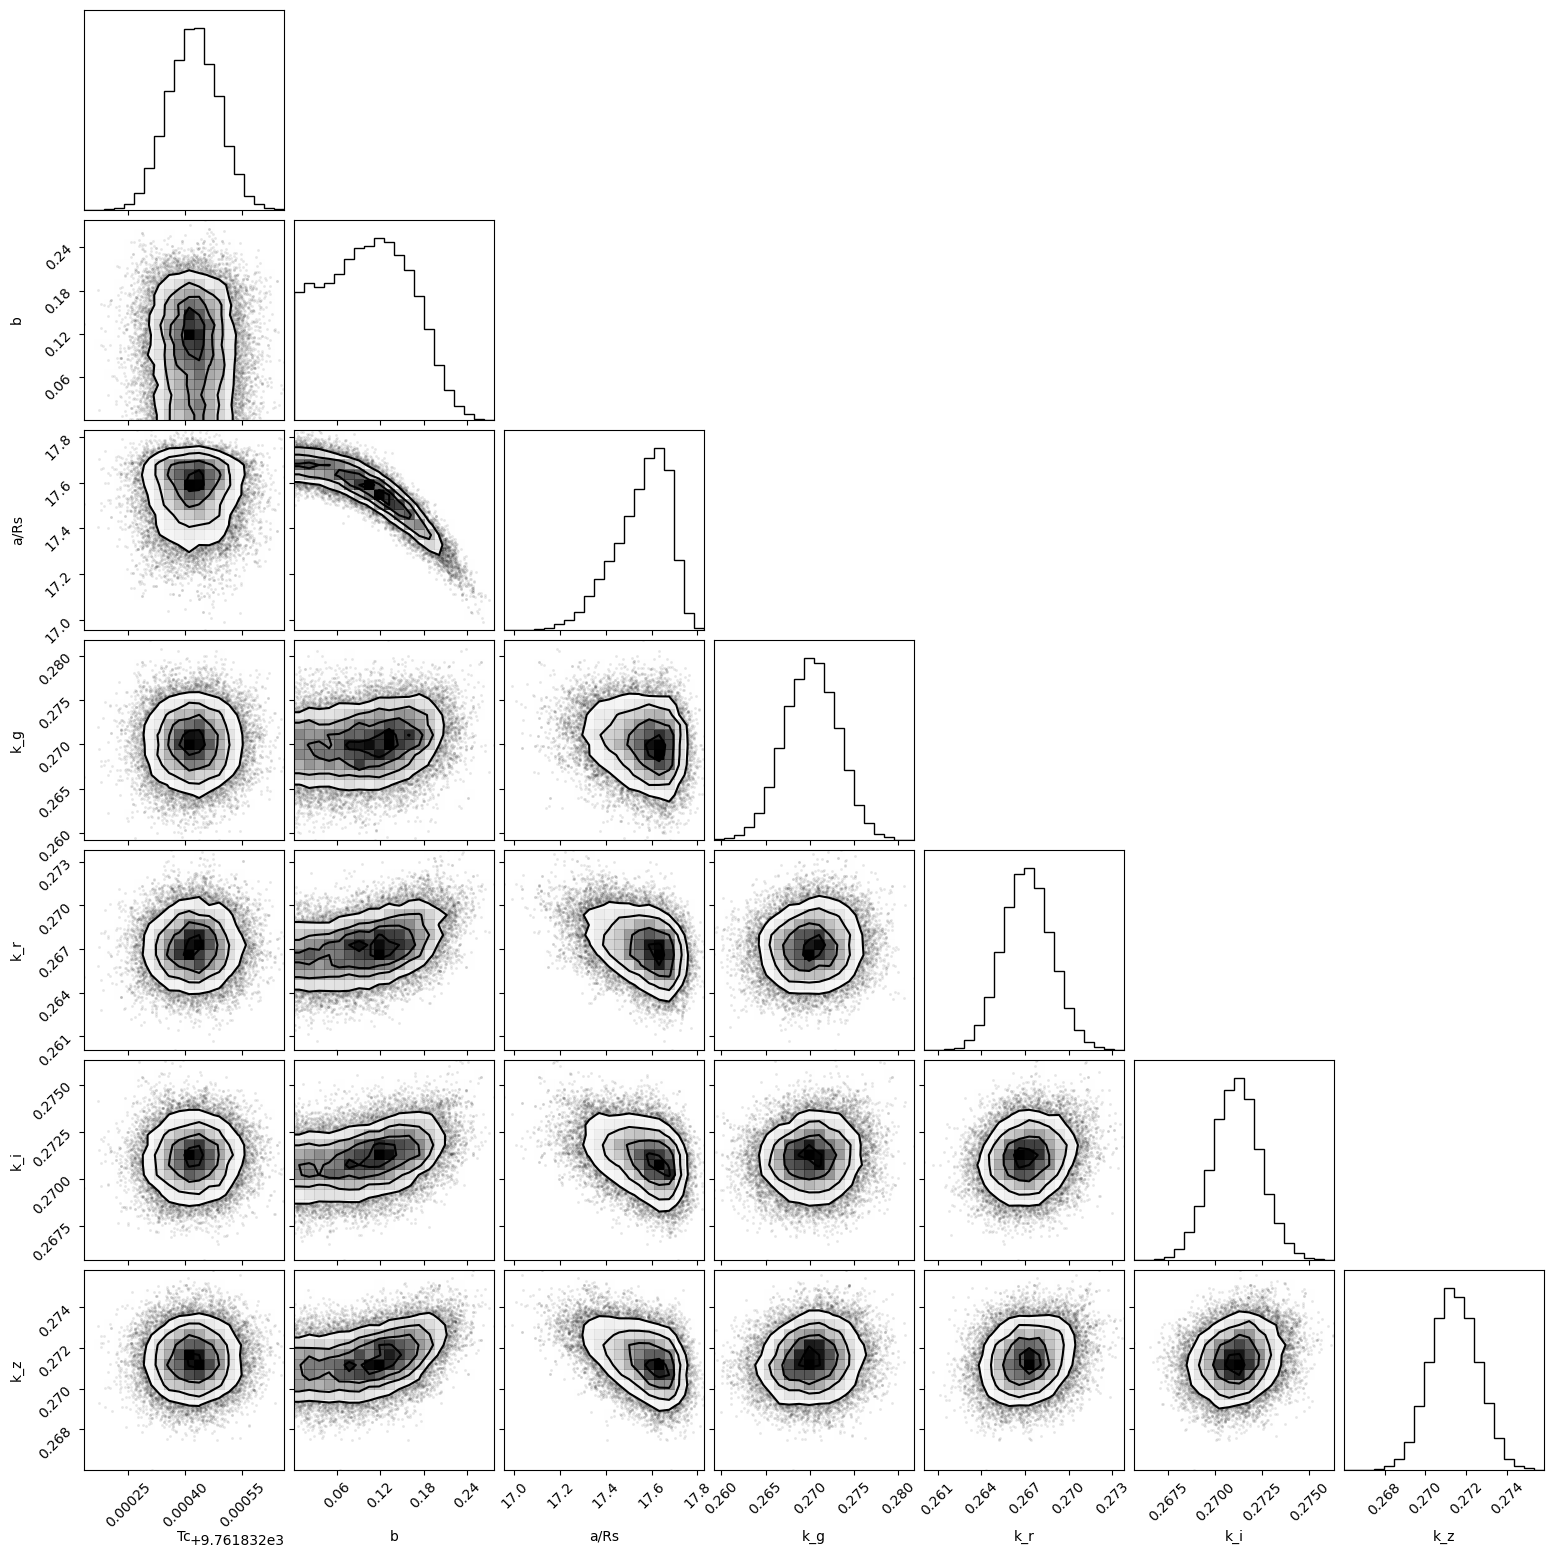

In [38]:
n0=5000
samples = sampler.get_chain(flat=True, discard=n0, thin=10)
import corner
samples[:,1] = np.sqrt(samples[:,1]*samples[:,1])
fig = corner.corner(samples[:,0:7], labels=['Tc', 'b', 'a/Rs', 'k_g', 'k_r', 'k_i', 'k_z'])#, 'k_r', 'k_i', 'k_z'])

In [39]:
val = lc.percentile(samples[:,0])
print('Tc = {0:.5f} +{1:.5f} -{2:.5f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
Tc_med, Tc_1h, Tc_1m = val[0], val[2]-val[0],val[0]-val[1]
val = lc.percentile(samples[:,1])
print('b = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
val = lc.percentile(samples[:,2])
print('a/Rs = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
val = lc.percentile(samples[:,3])
print('Rp/Rs(g) = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
val = lc.percentile(samples[:,4])
print('Rp/Rs(r) = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
val = lc.percentile(samples[:,5])
print('Rp/Rs(i) = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))
val = lc.percentile(samples[:,6])
print('Rp/Rs(z) = {0:.4f} +{1:.4f} -{2:.4f}'.format(val[0],val[2]-val[0],val[0]-val[1]))

Tc = 9761.83242 +0.00007 -0.00007
b = 0.1035 +0.0607 -0.0673
a/Rs = 17.5770 +0.0955 -0.1471
Rp/Rs(g) = 0.2702 +0.0030 -0.0030
Rp/Rs(r) = 0.2671 +0.0017 -0.0016
Rp/Rs(i) = 0.2711 +0.0013 -0.0013
Rp/Rs(z) = 0.2714 +0.0012 -0.0011


In [107]:
Tc_med,Tc_TFOP

(9824.012621535996, 2459824.0158951776)

In [40]:
## The TFOP report 
T0_gap=(Tc_med-Tc_TFOP)*24.*60. #minute
if T0_gap>0.:
    sigmaT=T0_gap/24./60./np.sqrt(Tc_1m**2+Tce_TFOP**2)
else:
    sigmaT=T0_gap/24./60./np.sqrt(Tc_1h**2+Tce_TFOP**2)
print('Transit lag from predicted: {0:.2f} minutes ({1:.2f} sigma)'.format(T0_gap,sigmaT))

Transit lag from predicted: -3527999131.46 minutes (-8851287.73 sigma)


In [61]:
samples[:,0]-intt0,xmodel-intt0

(array([0.83243316, 0.83247128, 0.83245658, ..., 0.83249558, 0.83252248,
        0.83237901]),
 array([-8.77913827e-01, -8.66786357e-01, -8.55658887e-01, -8.44531418e-01,
        -8.33403948e-01, -8.22276478e-01, -8.11149009e-01, -8.00021539e-01,
        -7.88894070e-01, -7.77766600e-01, -7.66639130e-01, -7.55511661e-01,
        -7.44384191e-01, -7.33256722e-01, -7.22129252e-01, -7.11001782e-01,
        -6.99874313e-01, -6.88746843e-01, -6.77619374e-01, -6.66491904e-01,
        -6.55364434e-01, -6.44236965e-01, -6.33109495e-01, -6.21982025e-01,
        -6.10854556e-01, -5.99727086e-01, -5.88599617e-01, -5.77472147e-01,
        -5.66344677e-01, -5.55217208e-01, -5.44089738e-01, -5.32962269e-01,
        -5.21834799e-01, -5.10707329e-01, -4.99579860e-01, -4.88452390e-01,
        -4.77324921e-01, -4.66197451e-01, -4.55069981e-01, -4.43942512e-01,
        -4.32815042e-01, -4.21687572e-01, -4.10560103e-01, -3.99432633e-01,
        -3.88305164e-01, -3.77177694e-01, -3.66050224e-01, -3.5492275

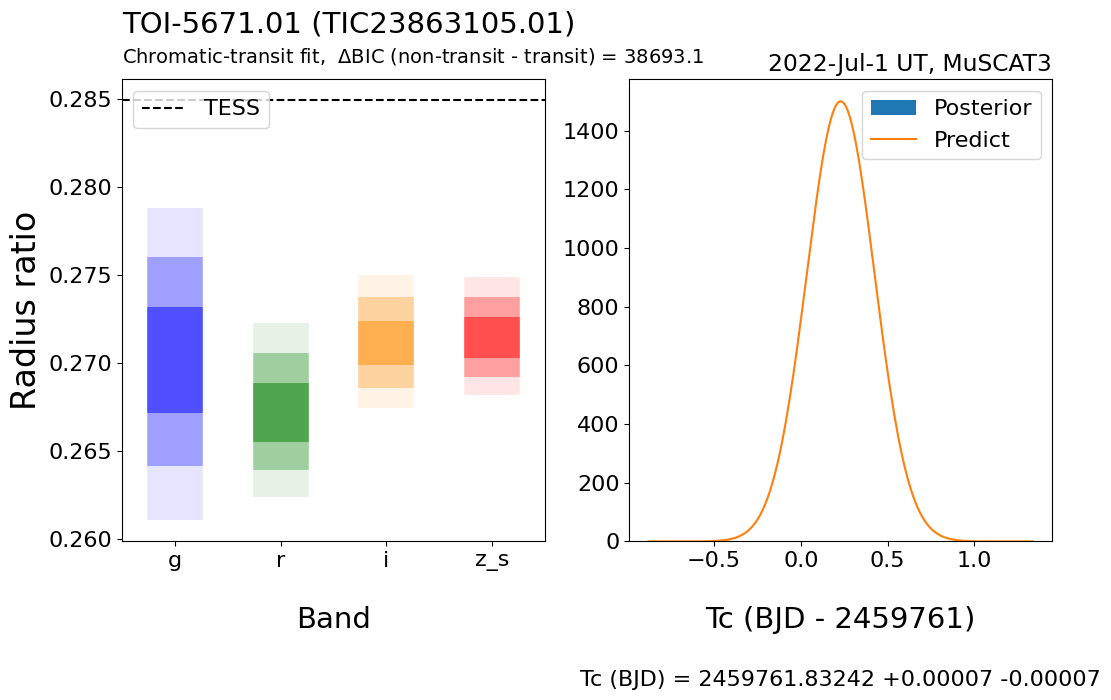

In [63]:
## make plots for Rp/Rs and Tc

Tc_med = lc.percentile(samples[:,0])[0]
b_med = lc.percentile(samples[:,1])[0]
a_Rs_med = lc.percentile(samples[:,2])[0]
inc_med = math.acos(b_med/a_Rs_med) 
d_med = []
d_med.append(lc.percentile(samples[:,7])[0])
d_med.append(lc.percentile(samples[:,8])[0])
d_med.append(lc.percentile(samples[:,9])[0])
d_med.append(lc.percentile(samples[:,10])[0])

bands = np.array((0,1,2,3))
k_val = []
k_val.append(lc.percentile(samples[:,3]))
k_val.append(lc.percentile(samples[:,4]))
k_val.append(lc.percentile(samples[:,5]))
k_val.append(lc.percentile(samples[:,6]))

k_med = np.zeros(len(bands))
k_err1 = np.zeros((len(bands), 2))
k_err2 = np.zeros((len(bands), 2))
k_err3 = np.zeros((len(bands), 2))
colors = ['blue','green','darkorange','red']

fig = plt.figure(figsize=(12,6))
fsize=16
plt.rcParams['font.size'] = fsize

ax0, ax1 = fig.subplots(1, 2)

ype1 = np.zeros((2,1))
ype2 = np.zeros((2,1))
ype3 = np.zeros((2,1))
for i in range(len(bands)):
    k_med[i] = k_val[i][0]
    k_err1[i] = np.array((k_val[i][0]-k_val[i][1], k_val[i][2]-k_val[i][0]))
    k_err2[i] = np.array((k_val[i][0]-k_val[i][3], k_val[i][4]-k_val[i][0]))
    k_err3[i] = np.array((k_val[i][0]-k_val[i][5], k_val[i][6]-k_val[i][0]))
    
    xp = (i)
    yp = (k_med[i])
    ype1[0,0], ype1[1,0] = k_val[i][0]-k_val[i][1], k_val[i][2]-k_val[i][0]
    ype2[0,0], ype2[1,0] = k_val[i][0]-k_val[i][3], k_val[i][4]-k_val[i][0]
    ype3[0,0], ype3[1,0] = k_val[i][0]-k_val[i][5], k_val[i][6]-k_val[i][0]
    ax0.errorbar(xp, yp, yerr=ype1, elinewidth=40, fmt='none', alpha=0.5, zorder=1, color=colors[i])
    ax0.errorbar(xp, yp, yerr=ype2, elinewidth=40, fmt='none', alpha=0.3, zorder=2, color=colors[i])
    ax0.errorbar(xp, yp, yerr=ype3, elinewidth=40, fmt='none', alpha=0.1, zorder=3, color=colors[i])

ax0.axhline(k_TFOP, linestyle='dashed', color='black', label='TESS')

ax0.set_xlim(-0.5,3.5)
ax0.set_xticks([0,1,2,3])
ax0.set_xticklabels(['g','r','i','z_s'])
ax0.set_ylabel('Radius ratio', fontsize=fsize*1.5)
fsize=14

#ax0.set_title(toi+' ('+tic+')', loc='left', fontsize=fsize*1.5)
target_name = 'TOI-{0}.{1} (TIC{2}.{1})'.format(toi,plnum,tic)
ax0.text(0., 1.12, target_name, horizontalalignment='left',\
         verticalalignment='center', transform=ax0.transAxes, fontsize=fsize*1.5)
ax0.text(0., 1.05, 'Chromatic-transit fit,  $\Delta$BIC (non-transit - transit) = {0:.1f}'.format(delta_bic),\
         horizontalalignment='left', verticalalignment='center', transform=ax0.transAxes, fontsize=fsize)

ax1.set_title(date4plot+', MuSCAT3', loc='right', fontsize=fsize*1.2)
ax0.set_xlabel('Band', labelpad=25, fontsize=fsize*1.5)
ax0.legend(loc='upper left')


intt0 = int(np.min(samples[:,0]))
#ax1.hist(samples[:,0]-intt0, bins=30, zorder=4, label='Posterior')
ax1.hist(samples[:,0]-intt0, bins=5000, zorder=5, label='Posterior')

Tc_TFOP = T0_TFOP + P_TFOP * epoch - 2450000
xmodel = np.linspace(Tc_TFOP-4*Tce_TFOP, Tc_TFOP+4*Tce_TFOP, 200)
ymodel = 1500 * np.exp( -(xmodel-Tc_TFOP)**2 / Tce_TFOP**2)
ax1.plot(xmodel-intt0, ymodel, label='Predict', zorder=5)

Tc_text = 'Tc (BJD) = {0:.5f} +{1:.5f} -{2:.5f}'.format(2450000+Tc_med, Tc_1h, Tc_1m)
ax1.text(0.5, -0.3, Tc_text, horizontalalignment='center',\
         verticalalignment='center', transform=ax1.transAxes)

ax1.set_xlabel('Tc (BJD - 245{0})'.format(intt0), labelpad=25, fontsize=fsize*1.5)
ax1.legend()
#ax1.set_xlim(-0.01,0.1)

#outfile = tic + '-' + plnum + '_20' + date + '_' + inst + '_grz_lcfit_chromatic.png'
outfile = outfile = 'TOI{0}.{1}L-{2}20{3}_{4}_griz_lcfit_chromatic_2.pdf'.format(toi, plnum, initial, date, INST[inst])
plt.savefig(outfile, bbox_inches='tight',pad_inches=0.1)
plt.show()

In [ ]:
##########
ymin1 = 0.89
ymax1 = 1.03
ymin2 = 0.89
ymax2 = 1.03
##########

0 rms = 0.0099
1 rms = 0.0066
2 rms = 0.0059
3 rms = 0.0049


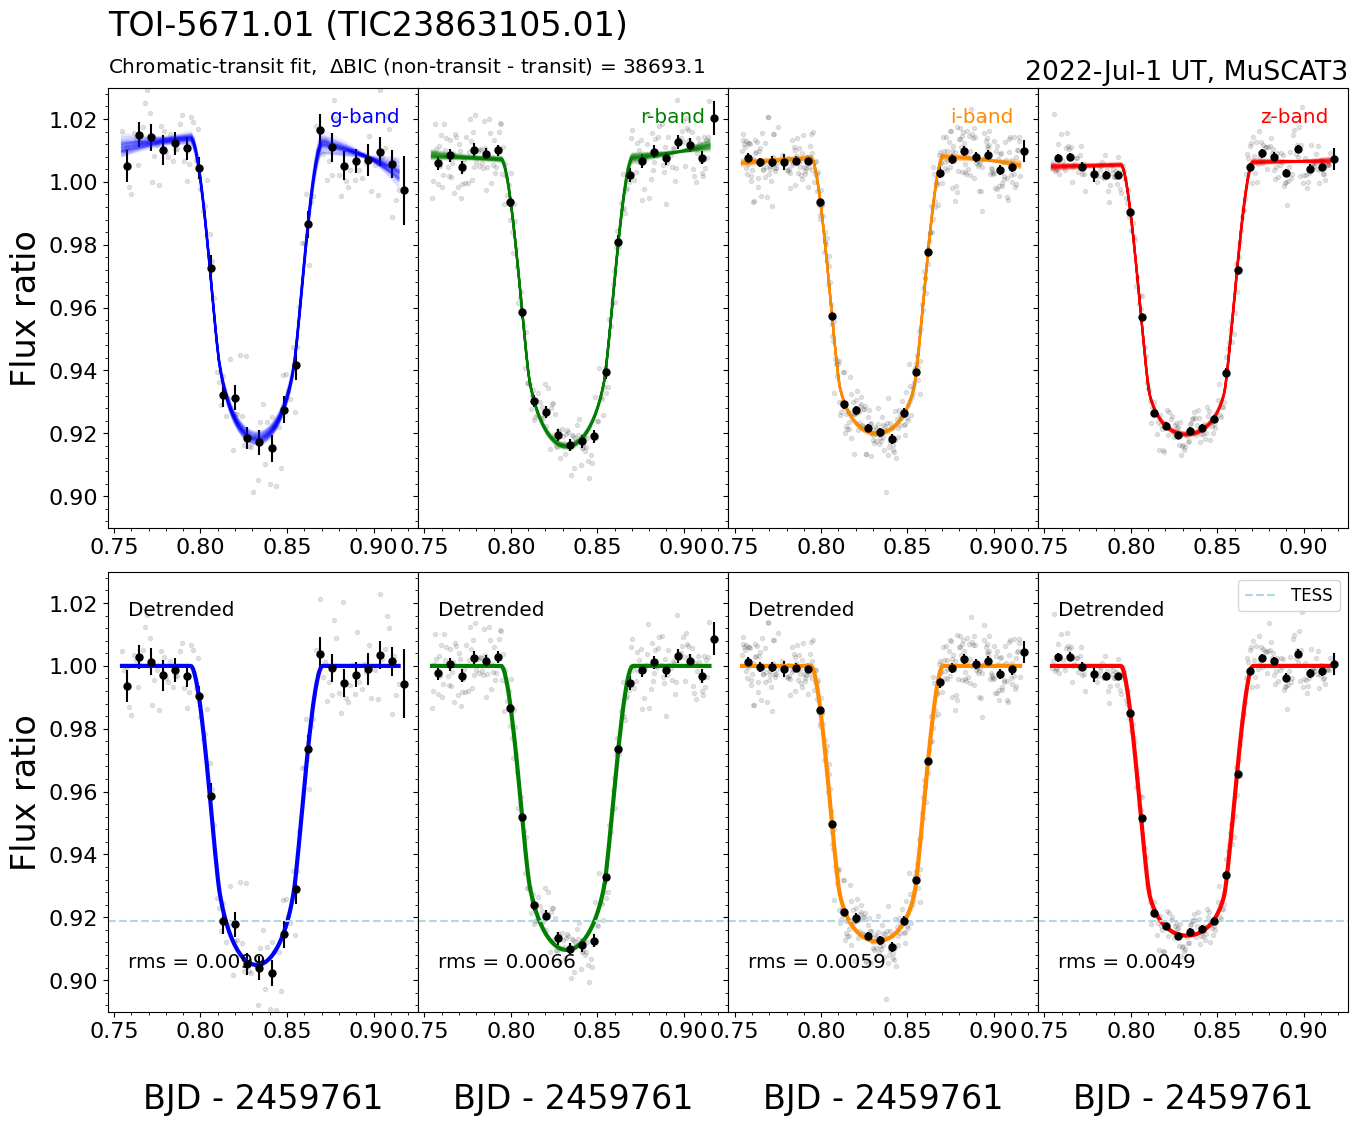

In [55]:
import math
from matplotlib.ticker import AutoMinorLocator

P=kwargs['P']
e=kwargs['e']
omega=kwargs['omega']

binsize = 600/86400.

bands = ['g-band', 'r-band', 'i-band', 'z-band']
colors = ['blue', 'green', 'darkorange', 'red']

k = np.zeros(nband)
nmodel = 100
msize = 5
fsize=24

fig, ax = plt.subplots(2,4,figsize=(16,12))
plt.subplots_adjust(hspace=0.1, wspace=0)
plt.rcParams['font.size'] = 16

x1 = [0.3, 0.5, 0.7]
x2 = [0.5, 0.7, 0.9]
y1 = [0.3, 0.6]
y2 = [0.6, 0.9]

depth=np.zeros(nband)
t0 = np.min(np.concatenate((x[0],x[1],x[2],x[3])))
intt0=int(t0)
            
for i in range(4):
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i]-intt0, y[i], ye[i], binsize, t0)

    ax[0,i].plot(x[i]-intt0,y[i],'.k',alpha=0.1)
    ax[0,i].errorbar(tbin, ybin, yerr=yebin, fmt='ok', markersize=msize)
 
    xmodel = np.linspace(np.min(x[i]), np.max(x[i]), 200)
    ttr_model = QuadraticModel()
    ttr_model.set_data(xmodel)

    rand = np.random.randint(len(samples), size=nmodel)
    
    for j in range(len(rand)):
        index = rand[j]
        Tc, b, a_Rs, k[0], k[1], k[2], k[3], d[0], d[1], d[2], d[3] = samples[index][:]
        inc = math.acos(b/a_Rs)
        flux_tr = ttr[i].evaluate_ps(k[i], ldc[i], Tc, P, a_Rs, inc, e, omega)
        flux_tr_time = d[i]*(x[i]-Tc) * flux_tr
        c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
        ax[0,i].plot(x[i]-intt0, flux_tr * (np.polyval(c, amass[i])+d[i]*(x[i]-Tc)), alpha=0.05, color=colors[i])

    flux_tr = ttr[i].evaluate_ps(k_med[i], ldc[i], Tc_med, P, a_Rs_med, inc_med, e, omega)
    flux_tr_time = d_med[i]*(x[i]-Tc_med) * flux_tr
    c = np.polyfit(amass[i], (y[i]-flux_tr_time)/flux_tr, 1)
    ymodel = ttr_model.evaluate_ps(k_med[i], ldc[i], Tc_med, P, a_Rs_med, inc_med, e, omega)
    depth[i]=1.-np.min(ymodel)
    rms = np.std( y[i] - flux_tr * (np.polyval(c, amass[i])+d_med[i]*(x[i]-Tc_med)) )
    rms_text = 'rms = {0:.4f}'.format(rms)
    print(i, rms_text)
    
    
    tbin, ybin, yebin=\
        lc.binning_equal_interval(x[i]-intt0, y[i]/(np.polyval(c, amass[i])+d_med[i]*(x[i]-Tc_med)), ye[i], binsize, t0)
    ax[1,i].plot(x[i]-intt0,y[i]/(np.polyval(c, amass[i])+d_med[i]*(x[i]-Tc_med)),'.k',alpha=0.1)
    ax[1,i].errorbar(tbin, ybin, yerr=yebin, fmt='ok', markersize=msize)
                    
    ax[1,i].plot(xmodel-intt0, ymodel, color=colors[i], linewidth=3)

    ax[0,i].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1,i].yaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,i].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1,i].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0,i].set_ylim(ymin1, ymax1)
    ax[1,i].set_ylim(ymin2, ymax2)
    
    tx = np.min(x[i]) + (np.max(x[i]) - np.min(x[i]))*0.75
    ty = ymin1 + (ymax1 - ymin1)*0.92
    ax[0,i].text(tx - intt0, ty, bands[i], color=colors[i], fontsize=fsize*0.6)
    
    tx = np.min(x[i]) + (np.max(x[i]) - np.min(x[i]))*0.02
    ty = ymin2 + (ymax2 - ymin2)*0.9
    ax[1,i].text(tx-intt0, ty, 'Detrended', fontsize=fsize*0.6)
    ty = ymin2 + (ymax2 - ymin2)*0.1
    ax[1,i].text(tx - intt0, ty, rms_text, fontsize=fsize*0.6)
    ax[1,i].axhline(1-k_TFOP**2, color='lightblue', linestyle='dashed', label='TESS')
    
    
    if(i==0):
        ax[0,i].set_ylabel('Flux ratio', fontsize=fsize)
        ax[1,i].set_ylabel('Flux ratio', fontsize=fsize)
        ax[0,i].tick_params(labelsize=16)
        ax[1,i].tick_params(labelsize=16)
        target_name = 'TOI-{0}.{1} (TIC{2}.{1})'.format(toi,plnum,tic)
        ax[0,i].text(0., 1.14, target_name, horizontalalignment='left',\
                 verticalalignment='center', transform=ax[0,i].transAxes, fontsize=fsize)
        ax[0,i].text(0., 1.05, 'Chromatic-transit fit,  $\Delta$BIC (non-transit - transit) = {0:.1f}'.format(delta_bic),\
                 horizontalalignment='left', verticalalignment='center', transform=ax[0,i].transAxes, fontsize=fsize*0.6)
        
    if(i==3):
        ax[0,i].set_title(date4plot+', MuSCAT3', loc='right', fontsize=fsize*0.8)
        
    if(i>0):
        ax[0,i].tick_params(labelleft=False, labelright=False, labeltop=False, labelsize=16)
        ax[1,i].tick_params(labelleft=False, labelright=False, labeltop=False, labelsize=16)

    ax[1,i].set_xlabel('BJD - 245{0}'.format(intt0), labelpad=30, fontsize=fsize)


ax[1,i].legend(loc='upper right', fontsize=12)
outfile = 'TOI{0}.{1}L-{2}20{3}_{4}_griz_lc_chromatic_2.pdf'.format(toi, plnum, initial, date, INST[inst])
plt.savefig(outfile,bbox_inches='tight',pad_inches=0.1)
plt.show()

In [56]:
## parameters which TFOP report requires
T0_gap=(Tc_med-Tc_TFOP)*24.*60. #minute
if T0_gap>0.:
    sigmaT=T0_gap/24./60./np.sqrt(Tc_1m**2+Tce_TFOP**2)
else:
    sigmaT=T0_gap/24./60./np.sqrt(Tc_1h**2+Tce_TFOP**2)
print('Transit lag from predicted: {0:.2f} minutes ({1:.2f} sigma)'.format(T0_gap,sigmaT))


print('Detected depth (g, r, i, z): {0:.2f} ppt, {1:.2f} ppt, {2:.2f} ppt, {3:.2f} ppt)'\
      .format(depth[0]*1e3,depth[1]*1e3,depth[2]*1e3,depth[3]*1e3))

Transit lag from predicted: 868.54 minutes (2.18 sigma)
Detected depth (g, r, i, z): 95.16 ppt, 90.38 ppt, 87.61 ppt, 85.82 ppt)


In [ ]:
Tc_med